# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [1]:
#give google drive permission
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1870 sha256=b95d788567f3fe3c7e5753430a60102f2f3b11641ac1f92af57a823325e8f301
  Stored in directory: /root/.cache/pip/wheels/e3/d2/c9/ba15b05ba596e2eafeb83c2903e79d634207367555aae8c7d2
Successfully built pycrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.4 MB/s eta 0:00:00


##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

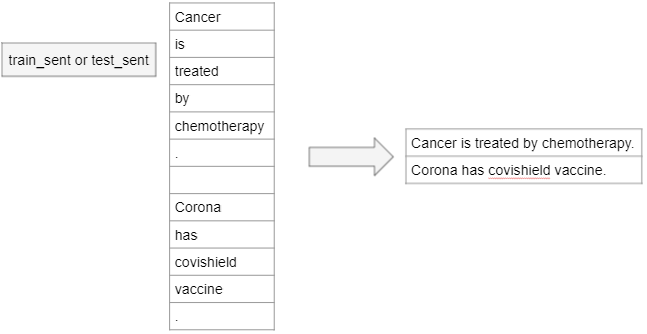

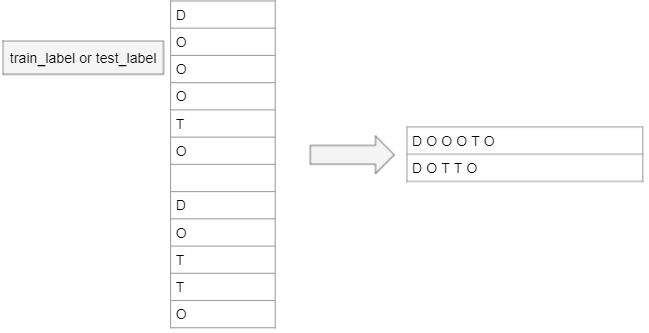

In [3]:
with open('/content/drive/MyDrive/Colab_Notebooks/NER_Assignment_data/train_sent', 'r', encoding="utf-8") as train_sent_file:
  train_words = train_sent_file.readlines()

print(train_words)
print(len(train_words))

['All\n', 'live\n', 'births\n', '>\n', 'or\n', '=\n', '23\n', 'weeks\n', 'at\n', 'the\n', 'University\n', 'of\n', 'Vermont\n', 'in\n', '1995\n', '(\n', 'n\n', '=\n', '2395\n', ')\n', 'were\n', 'retrospectively\n', 'analyzed\n', 'for\n', 'delivery\n', 'route\n', ',\n', 'indication\n', 'for\n', 'cesarean\n', ',\n', 'gestational\n', 'age\n', ',\n', 'parity\n', ',\n', 'and\n', 'practice\n', 'group\n', '(\n', 'to\n', 'reflect\n', 'risk\n', 'status\n', ')\n', '\n', 'The\n', 'total\n', 'cesarean\n', 'rate\n', 'was\n', '14.4\n', '%\n', '(\n', '344\n', 'of\n', '2395\n', ')\n', ',\n', 'and\n', 'the\n', 'primary\n', 'rate\n', 'was\n', '11.4\n', '%\n', '(\n', '244\n', 'of\n', '2144\n', ')\n', '\n', 'Abnormal\n', 'presentation\n', 'was\n', 'the\n', 'most\n', 'common\n', 'indication\n', '(\n', '25.6\n', '%\n', ',\n', '88\n', 'of\n', '344\n', ')\n', '\n', 'The\n', '``\n', 'corrected\n', "''\n", 'cesarean\n', 'rate\n', '(\n', 'maternal-fetal\n', 'medicine\n', 'and\n', 'transported\n', 'patients\n', 'e

In [4]:
# Clean and split words
train_sentences = []
current_sentence = []

for line in train_words:
    stripped = line.strip()
    if stripped == "":
        if current_sentence:
            train_sentences.append(current_sentence)
            current_sentence = []
    else:
        current_sentence.append(stripped)

if current_sentence:
    train_sentences.append(current_sentence)

In [6]:
for sentence in train_sentences[:5]:
  print(sentence)

['All', 'live', 'births', '>', 'or', '=', '23', 'weeks', 'at', 'the', 'University', 'of', 'Vermont', 'in', '1995', '(', 'n', '=', '2395', ')', 'were', 'retrospectively', 'analyzed', 'for', 'delivery', 'route', ',', 'indication', 'for', 'cesarean', ',', 'gestational', 'age', ',', 'parity', ',', 'and', 'practice', 'group', '(', 'to', 'reflect', 'risk', 'status', ')']
['The', 'total', 'cesarean', 'rate', 'was', '14.4', '%', '(', '344', 'of', '2395', ')', ',', 'and', 'the', 'primary', 'rate', 'was', '11.4', '%', '(', '244', 'of', '2144', ')']
['Abnormal', 'presentation', 'was', 'the', 'most', 'common', 'indication', '(', '25.6', '%', ',', '88', 'of', '344', ')']
['The', '``', 'corrected', "''", 'cesarean', 'rate', '(', 'maternal-fetal', 'medicine', 'and', 'transported', 'patients', 'excluded', ')', 'was', '12.4', '%', '(', '273', 'of', '2194', ')', ',', 'and', 'the', '``', 'corrected', "''", 'primary', 'rate', 'was', '9.6', '%', '(', '190', 'of', '1975', ')']
['Arrest', 'of', 'dilation', '

In [7]:
def process_file(file_path):
  input_file = open(file_path, 'r')
  file_content = input_file.readlines()
  input_file.close()

  out_lines = []

  line_content = ""

  for word in file_content:
    word = word.strip()
    if word == "":
      out_lines.append(line_content)
      line_content = ""
    else:
      if line_content:
        line_content += " " +word
      else:
        line_content = word
  return out_lines

In [8]:
# importing files

train_sentences = process_file('/content/drive/MyDrive/Colab_Notebooks/NER_Assignment_data/train_sent')
train_labels = process_file('/content/drive/MyDrive/Colab_Notebooks/NER_Assignment_data/train_label')
test_sentences = process_file('/content/drive/MyDrive/Colab_Notebooks/NER_Assignment_data/test_sent')
test_labels = process_file('/content/drive/MyDrive/Colab_Notebooks/NER_Assignment_data/test_label')

In [17]:
for i in range(5):
  print("Sentence", f"{i} with length {len(train_sentences[i].split())}:", train_sentences[i])
  print("Labels", f"{i} with length {len(train_labels[i].split())}:", train_labels[i], "\n\n")

Sentence 0 with length 45: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Labels 0 with length 45: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 


Sentence 1 with length 25: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Labels 1 with length 25: O O O O O O O O O O O O O O O O O O O O O O O O O 


Sentence 2 with length 15: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Labels 2 with length 15: O O O O O O O O O O O O O O O 


Sentence 3 with length 38: The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Labels 3 with length 38: O O O O O O O O 

### Count the number of sentences in the processed train and test dataset

In [20]:
print("No. of lines in tarin_sentences:", len(train_sentences))
print("No. of lines in test_sentences:", len(test_sentences))

No. of lines in tarin_sentences: 2599
No. of lines in test_sentences: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [19]:
print("No. of lines in train_labels:", len(train_labels))
print("No. of lines in test_labels:", len(test_labels))

No. of lines in train_labels: 2599
No. of lines in test_labels: 1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

## Defining features for CRF





In [ ]:
# Let's define the features to get the feature value for one word.


## Getting the features

### Write a code/function to get the features for a sentence

In [ ]:
# Write a code to get features for a sentence.


### Write a code/function to get the labels of a sentence

In [ ]:
# Write a code to get the labels for a sentence.


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

### Define the labels as the target variable for test and the train dataset

## Build the CRF Model

In [ ]:
# Build the CRF model.


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

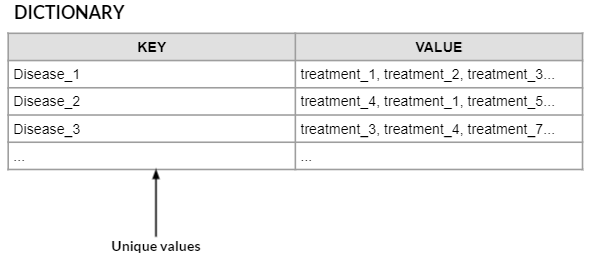

### Predict the treatment for the disease name: 'hereditary retinoblastoma'